# Principles of Data Science

### Lecture 17: Limit Setting

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## Limit Setting

- Today's lecture covers procedures for setting limits 

- Learning objectives:
    - Recall how to set upper (or lower) limits on quantities using Feldman-Cousins
    - Understand and be able to apply the CLs limit setting method

## Recap

- Concept of a confidence band

<img src="plots/conf_belt_norm.png" alt="drawing">

- Use of Feldman-Cousins method when near a physical boundary

<img src="plots/fc_norm.png" alt="drawing" width="600">

- Concept of hypothesis testing between $H_0$ and $H_1$

<img src="plots/hypothesis_test.png" alt="drawing" width="600">

## Limit Setting

- Limit setting is useful if we do not have sufficient precision to make a measurement
- Allows us to exclude certain hypotheses
- The typical use case is in <font color="blue">searches for signals</font>
    - small signal on top of a (small or large) background
    
- It is clear in this case there are two hypotheses:
    - $H_0$ (the null) is the **background only** hypothesis
    - $H_1$ (the alternate) is the **signal plus background** hypothesis

## Signal searches

- The null hypothesis, $H_0$, (background only) is a **subset** of the alternate hypothesis
- Imagine a model of the form

$$ p(X; \vec{\theta}) = f s(X; \vec{\theta}_s) + (1-f) b(X; \vec{\theta}_b) $$

- $H_0$ is a subset of the model where $f=0$
- $H_1$ is then a continuous set of models with different values of $f$
- We would normally consider the one at the best-fit value in our data $\hat{f}$ to be **the** alternate

- Recall that the test-statistic we should use is the log-likelihood ratio

$$ T = -2\ln \left( \frac{ L(f=\hat{f}) }{L( f=0)} \right) $$

- The test-statistic will then take some distribution under the different hypotheses
- The null distribution does not change
- The alternate will change depending on the value of $f$
- The data will only ever take a **single** value of $T$

<img src="plots/test_stat_dist.png" alt="drawing" width="600">

- Based on this I can then decide whether to accept or reject the null hypothesis

- Can reject $H_0$ with confidence $\alpha$

$$ \alpha = \int_{T_0}^\infty p(T|H_0) dT $$

- Or may decide to reject $H_1$ with confidence $1-\beta$

$$ 1-\beta = \int_\infty^{T_0} p(T|H_1) dT $$

## And to set a limit?

- So what if I see something consistent with $H_0$ and I want to set a limit on the value of $f$ at some confidence level $\beta$?
- Now I have to find the value of $f$ (call this $f_{\text{lim}}$) for which I get the desired $\beta$

$$ 1 - \beta = \int_\infty^{T_0} p(T|H_1) dT $$

- This means I can now state: "values of $f>f_{\text{lim}}$ are excluded at $\beta\%$ C.L."

<img src="plots/test_stat_dist2.png" alt="drawing" width="600">

- This is known as the **"observed"** limit
- Quite often see it drawn as a function of the signal rate (the red line below)

<img src="plots/lhcb-limit-curve.png" alt="drawing" width="800">

- But what are all these other lines for?

## Expected limits

- Our data is always just some sample from the **"true"** distribution
- We are always interested in our data of course
- But we are also often interested in the "ensemble" of all possible datasets we **could have** got
- This is where the expected line and expected band come in
    - the expected limit is the median 
    - the band is the quantile at some CL
    
<img src="plots/test_stat_dist3.png" alt="drawing" width="600">

## Set up an example

 - First some code to setup the model

In [1]:
import numpy as np
np.random.seed(210187)
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')
from scipy.stats import uniform, norm

In [2]:
# obs range
xrange = (3,3.5)

# true pars
mu = 3.25
sg = 0.05
fr = 0.1
Nevs = 500

# models
def smodel(x, mu, sg):
    return norm.pdf(x, mu, sg)

def bmodel(x):
    return uniform.pdf(x, xrange[0], xrange[1]-xrange[0])

def model(x, f, mu, sg):
    return f*smodel(x,mu,sg) + (1-f)*bmodel(x)

def density(x, Ns, mu, sg, Nb):
    return Ns+Nb, Ns*smodel(x,mu,sg) + Nb*bmodel(x)


- then some code to setup a generation

In [3]:
def generate(Ns, mu, sg, Nb, poiss=True):
    smodel = norm(mu,sg)
    bmodel = uniform(xrange[0], xrange[1]-xrange[0])
    
    if poiss:
        Ns = np.random.poisson( Ns )
        Nb = np.random.poisson( Nb )

    bevs = bmodel.rvs(size=Nb)
    sevs = smodel.rvs(size=Ns)

    dset = np.concatenate([bevs,sevs])
    
    return dset
    
    

- next let's generate what we will call our "data"

In [4]:
dset = generate( Ns=fr*Nevs, mu=mu, sg=sg, Nb=(1-fr)*Nevs )

In [5]:
# write a fitting function
from iminuit import cost, Minuit

def fit(dset, verbose=False):
    nll = cost.ExtendedUnbinnedNLL(dset, density)
    mi = Minuit(nll, Ns=fr*Nevs, mu=mu, sg=sg, Nb=(1-fr)*Nevs)
    mi.limits['Ns','Nb'] = (0,3*Nevs)
    mi.limits['mu'] = xrange
    mi.limits['sg'] = (0,0.5)

    # free fit
    mi.migrad()
    mi.hesse()
    sb_nll = mi.fval
    sb_vals = list(mi.values)
    if verbose:
        print(mi)

    # b-only fit
    mi.values['Ns'] = 0
    mi.fixed['Ns','mu','sg'] = True
    mi.migrad()
    mi.hesse()
    bo_nll = mi.fval
    bo_vals = list(mi.values)
    if verbose:
        print(mi)
        
    n2ll = -2*(sb_nll-bo_nll)
     
    return n2ll, sb_vals, bo_vals


- run the fit to our pretend data

In [6]:
T0, sb_vals, bo_vals = fit(dset)

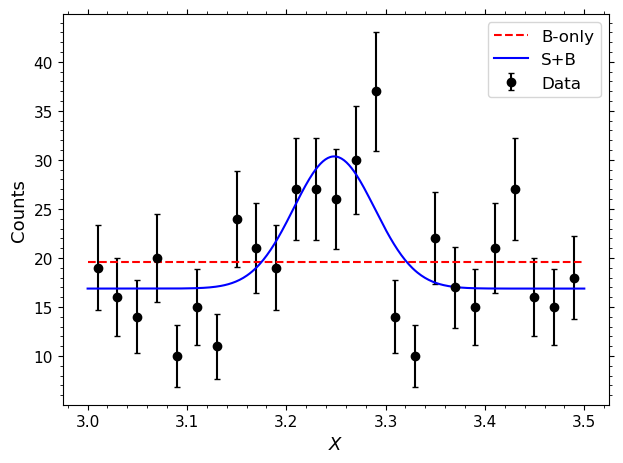

In [7]:
# write a plotting function to check it looks ok
def plot(dset, sb_vals, bo_vals):
    
    fig, ax = plt.subplots()
    nh, xe = np.histogram(dset, bins=25)
    cx = 0.5*(xe[:-1]+xe[1:])
    bw = xe[1]-xe[0]
    
    ax.errorbar(cx, nh, nh**0.5, fmt='ko', label='Data')
    
    x = np.linspace(*xrange, 400)
    
    ax.plot( x, bw*density(x, *bo_vals)[1], 'r--', label='B-only' )
    ax.plot( x, bw*density(x, *sb_vals)[1], 'b-' , label='S+B')
    
    ax.legend()
    
    ax.set_xlabel('$X$')
    ax.set_ylabel('Counts')
    
plot(dset, sb_vals, bo_vals)

## Now actually generate the $H_1$ distribution

- Going to simulate a series of "pseudo-experiments" which mimic some $H_1$ hypothesis

In [8]:
from tqdm import tqdm
ntoys = 2000
gen_vals = sb_vals
sb_test_stats = []
for i in tqdm(range(ntoys)):
    toy = generate(*gen_vals) 
    ll, sb, bo = fit(toy)
    sb_test_stats.append(ll)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.10it/s]


Text(0.5, 0, '$T$')

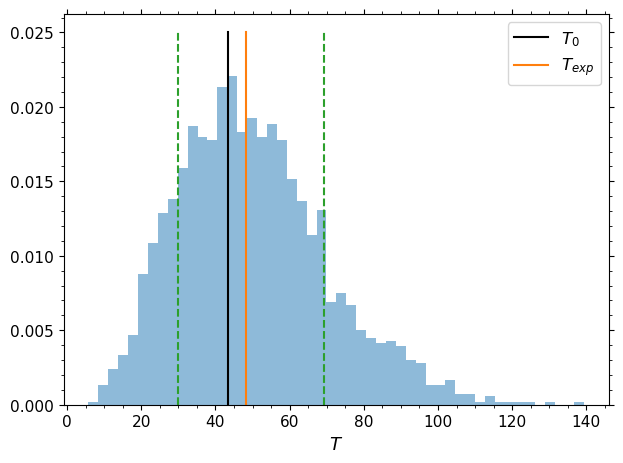

In [11]:
# find expected point and band
from scipy.stats import chi2
Texp = np.median( sb_test_stats)
qlow = (1-chi2.cdf(1,1))/2
qup = 1-qlow
Tlow, Tup = np.quantile( sb_test_stats, [qlow, qup] )

plt.hist(sb_test_stats, density=True, bins=50, alpha=0.5)
plt.plot( [T0, T0], [0,0.025], label='$T_0$', c='k')
plt.plot( [Texp, Texp], [0, 0.025], label='$T_{exp}$' )
plt.plot( [Tlow, Tlow], [0, 0.025], c='C2', ls='--')
plt.plot( [Tup, Tup], [0, 0.025], c='C2', ls='--')
plt.legend()
plt.xlabel('$T$')

# <font color="darkred">*Musical interlude...*</font>

## The $CL_s$ method

- What you may realise is that we have a bit of an issue if our data is not consistent with either $H_0$ nor $H_1$ and we have poor sensitivity to their separation
- For example, imagine a downward fluctuation in data and poor $H_0$ and $H_1$ separation (i.e. little or no sensitivity to the signal)

<img src="plots/test_stat_dist4.png" alt="drawing" width="600">

- But I would rule out the signal here, even though I am not sensitive to it
- Many consider this poor practise

- Thus the so-called $CL_s$ method is introduced to overcome this specific problem
- The limits or exclusion region we have found previously (and called $\beta$) is the $1-CL_{sb}$ region with $p$-value denoted by $p_{sb}$
- The $CL_s$ method simply weights this by the equivalent region for $H_0$ only, i.e. the $CL_b$ region so that

$$ p_{s} = \frac{ p_{sb} } { 1-p_{b} } $$

<img src="plots/test_stat_dist5.png" alt="drawing" width="600">

- Thus is there perfect discrimination between $H_0$ and $H_1$ are $p$-value gets scaled by 1
- Otherwise it is scaled by something smaller than 1 (potentially much smaller) meaning our exclusion gets worse

## The CLs method

- The CLs method is (intentionally) conservative
- It is meant to protect against *false* exclusions
- It should be noted that it will in general overcover unless $H_0$ and $H_1$ are easily distinguishable

<img src="plots/cls_coverage.png" alt="drawing" width="600">

## Applying CLs to the example above

- Now need to generate some background only pseudo-experiments as well

In [12]:
gen_vals = bo_val s
bo_test_stats = []
for i in tqdm(range(ntoys)):
    toy = generate(*gen_vals) 
    ll, sb, bo = fit(toy)
    bo_test_stats.append(ll)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:52<00:00, 37.93it/s]


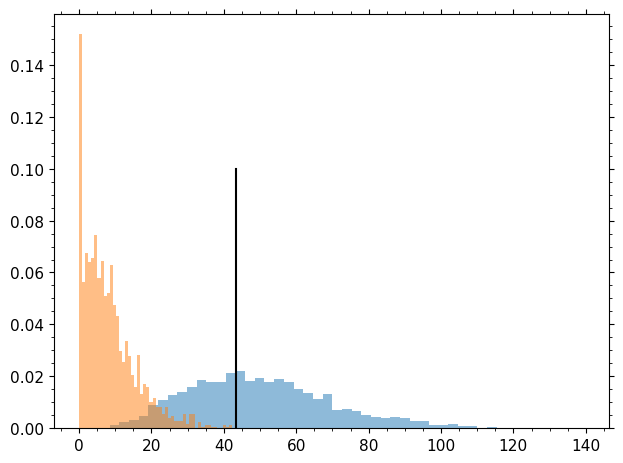

In [14]:
plt.hist(sb_test_stats, density=True, bins=50, alpha=0.5)
plt.hist(bo_test_stats, density=True, bins=50, alpha=0.5)
plt.plot( [T0, T0], [0,0.1], label='$T_0$', c='k')

- Actually in this case see that the separation is already good
- Count fraction of "toys" below the observation

In [18]:
sb_test_stats = np.asarray( sb_test_stats )
bo_test_stats = np.asarray( bo_test_stats )
CLsb = len( sb_test_stats[sb_test_stats < T0] ) / 2000
CLb  = len( bo_test_stats[bo_test_stats < T0] ) / 2000

CLs = CLsb / CLb
print(CLsb, CLb, CLs)

0.4035 1.0 0.4035


- Comments and thoughts here
- Recall that to find the signal rate (or Ns) value excluded at X\% CL (rather than just this pathetic 60\%)
    - Run toys for $H_1$ at higher values of $N_s$ and find where this crosses to generate the plot like

<img src="plots/lhcb-limit-curve.png" alt="drawing" width="600">

# End of Lecture Number

By the end of this lecture you should:
   - Recall how to set upper (or lower) limits on quantities using Feldman-Cousins
   - Understand and be able to apply the CLs limit setting method